<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li></ul></div>

# Защита персональных данных клиентов

Нам нужно защитить данные клиентов страховой компании «Хоть потоп». Необходимо разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, а также обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

try:
    data = pd.read_csv('/datasets/insurance.csv')
except:
    data = pd.read_csv('home/an4ouce/datasets/insurance.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [2]:
data.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


В датафрейме 5 столбцов и 5000 строк, содержащих следующие данные о клиентах:
* пол (категориальный признак, 0 или 1);
* возраст;
* зарплата;
* количество членов семьи;
* количество страховых выплат.

In [3]:
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Пропусков в датафрейме нет. Аномалий не наблюдается. 
* Возраст клиентов - от 18 до 65 лет;
* Зарплата - от 5 300 у.е. до 79 000 у.е.;
* Количество членов семьи - от 0 до 6;
* Количество страховых выплат - от 0 до 5.

Проверим датафрейм на полные дубликаты:

In [4]:
data.duplicated().sum()

153

153 задублированные строки. Но в данном датафрейме нет привязки к ID клиента, потому вполне может быть, что у разных клиентов все признаки одинаковые. Оставим их.

Взглянем на гистограмму страховых выплат:

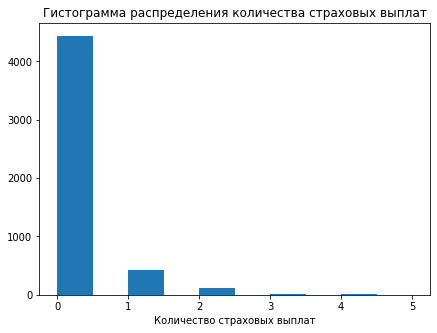

In [5]:
plt.figure(figsize=[7,5])

plt.hist(data['Страховые выплаты'])

plt.xlabel('Количество страховых выплат')
plt.title('Гистограмма распределения количества страховых выплат')

plt.show()

С огромным отрывом лидирует нулевое количество страховых выплат, что говорит о том, что страхование - весьма прибыльный бизнес.

Посмотрим на корреляцию числовых признаков:

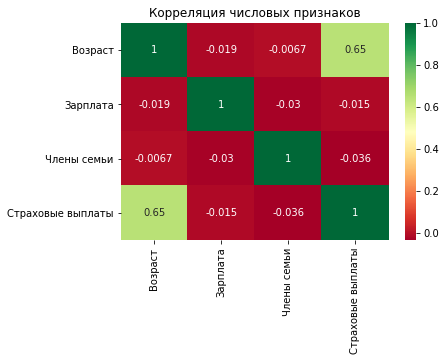

In [6]:
sns.heatmap(data[['Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты']].corr(), cmap='RdYlGn', annot=True)
plt.title('Корреляция числовых признаков')
plt.show()

Мультиколлинеарности нет. Как видно из тепловой карты, самое большое влияние на количество страховых выплат оказывает возраст клиента. Построим диаграмму рассеяния:

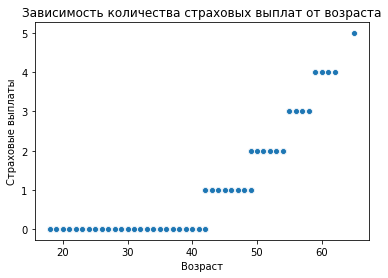

In [7]:
sns.scatterplot(data=data, x='Возраст', y='Страховые выплаты')
plt.title('Зависимость количества страховых выплат от возраста')
plt.show()

Интересная зависимость. Самые прибыльные клиенты для страховой компании - от 18 до 43 лет. Клиенты возрастом от 43 до 50 лет уже имеют по одной страховой выплате. От 50 до 55 лет - 2 выплаты. Действительно, с увеличением возраста клиента увеличивается количество страховых выплат. 

**Вывод:** анализ провели, можно приступать к разработке алгоритма защиты данных клиентов.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $Z$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** при умножении матрицы признаков на произвольную обратимую матрицу, предсказания $a$ не изменятся. 

**Обоснование:** обозначим $Z$ произвольную обратимую матрицу. Тогда произведение такой матрицы на нашу исходную матрицу будет $XZ$. Подставим произведение $XZ$ в формулу обучения модели вместо $X$:

$$w_{new} = ((XZ)^T XZ)^{-1} (XZ)^T y$$







Теперь подставим $w_{new}$ в формулу предсказаний и вычислим $a_{new}$:

$$a_{new} = XZ w_{new} = XZ ((XZ)^TXZ)^{-1}(XZ)^T y$$

Преобразуем дальше по свойству транспонирования матрицы $(AB)^T = B^T A^T$:

$$a_{new} = XZ(Z^T X^T XZ)^{-1} Z^T X^T y$$

Преобразуем дальше по свойству матрицы $(AB)^{-1} = B^{-1} A^{-1}$:

$$a_{new} = XZ (X^T XZ)^{-1} (Z^T)^{-1} Z^T X^T y = XZ Z^{-1} (X^T X)^{-1} (Z^T)^{-1} Z^T X^T y$$

Преобразуем дальше с учетом определения единичной матрицы $A A^{-1} = E$:

$$a_{new} = XE (X^T X)^{-1} E X^T y = X (X^T X)^{-1} X^T y = a$$

Доказали, что при умножении матрицы признаков на произвольную обратимую матрицу предсказания модели не изменятся.

## Алгоритм преобразования

**Алгоритм**

1. Записываем в переменные признаки и целевой признак
2. Создаем произвольную обратимую матрицу
3. Обучаем модель без преобразования
4. Считаем метрику R2 на модели без преобразования
5. Умножаем произвольную обратимую матрицу на матрицу признаков
6. Обучаем модель с учетом преобразования
7. Считаем метрику R2 на преобразованных данных
8. Сравниваем значения полученных метрик

**Обоснование**

Умножим нашу матрицу признаков на произвольную обратимую матрицу, обучим модель на преобразованных данных. Качество модели не должно измениться в результате такого преобразования, а персональные данные клиентов будут зашифрованы таким способом.

## Проверка алгоритма

Выделим признаки и целевой признак:

In [8]:
features = data.drop('Страховые выплаты', axis=1).values
target = data['Страховые выплаты'].values

Напишем функцию, генерирующую случайную обратимую матрицу. Предусмотрим случай, когда матрица может сгенерироваться необратимая. В этом случае функция автоматически сгенерирует новую матрицу.

In [9]:
def check_matrix():
    matrix = np.random.normal(size=(4,4))
    print('Случайная матрица', matrix)
    try:
        matrix_inv = np.linalg.inv(matrix)
        print('Обратная матрица', matrix_inv)
    except:
        print('Матрица необратима, генерирую новую')
        matrix = np.random.normal(size=(4,4))
        print('Новая матрица', matrix)
        matrix_inv = np.linalg.inv(matrix)
        print('Обратная матрица для новой', matrix_inv)
    return matrix_inv

Теперь воспользуемся функцией и выведем на экран случайную матрицу и обратную ей.

In [10]:
matrix_inv = check_matrix()

Случайная матрица [[-0.25263341 -0.6874642  -0.03240032  0.99769446]
 [-0.23040974  0.81055871 -0.39521065 -0.11412161]
 [ 2.48518994  0.24247103  0.8451323  -0.90015485]
 [-0.20261402  1.67079478 -1.33685745  0.43621186]]
Обратная матрица [[-0.24082079 -1.68888768  0.27676709  0.68008289]
 [ 1.38674515  4.43332746  0.46644671 -1.04934153]
 [ 2.41416716  6.72519911  0.67591868 -2.36737986]
 [ 1.97527211  2.84554354  0.41343921 -0.62772418]]


Обучим модель на исходных данных и посчитаем метрику R2:

In [11]:
model=LinearRegression()
model.fit(features, target)
predictions = model.predict(features)
print('R2 исходной модели: ', (r2_score(target, predictions)).round(3))

R2 исходной модели:  0.425


Преобразуем данные: матрицу признаков умножим на произвольную обратимую матрицу. Обучим модель на преобразованных данных и посчитаем метрику R2:

In [12]:
new_features = features @ matrix_inv
model.fit(new_features, target)
predictions_new = model.predict(new_features)
print('R2 преобразованной модели: ', (r2_score(target, predictions_new)).round(3))

R2 преобразованной модели:  0.425


**Вывод:** как видим, метрики R2 модели, обученной на исходных и преобразованных данных, не отличаются, а значит, задача защиты персональных данных клиента выполнена.